<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_text_analyis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Full Text Parquet Derivatives

In this notebook, we'll setup an enviroment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives and generally small enough to work with on your local machine, and can be easily converted to Pandas DataFrames as demostrated below.

**Web Pages**

`.webpages()` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `content`


# Dataset

We will need a web archive dataset to work with.

The one we'll use in this example notebook comes from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup banq!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3599771.svg)](https://doi.org/10.5281/zenodo.3599771)

Curious about the size the derivative Parquet output compared to the size of the web archive collection?

The total size of all 12 Parquet deriatives is 594M, with `webpages` being the largest (525M) since it has a column with full text (`content`).

```
2.5M	./videos
344K	./domains
1.7M	./word-processor-files
24K	./presentation-program-files
1.7M	./spreadsheets
880K	./audio
4.4M	./images
528M	./webpages
1.7M	./text-files
3.9M	./pdfs
29M	./webgraph
22M	./imagelinks
594M	.
```

The total size of the web archive collection is 165G.

In [0]:
%%capture

!curl -L "https://zenodo.org/record/3599771/files/environnement-qc.tar.gz?download=1" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

In [2]:
!ls -1 parquet

audio
domains
imagelinks
images
pdfs
presentation-program-files
spreadsheets
text-files
videos
webgraph
webpages
word-processor-files


# Environment

Next, we'll setup our environment so we can work with the Parquet output with Pandas.

In [0]:
%%capture

!apt-get update
!apt-get install -y openjdk-8-jdk-headless -qq 
!apt-get install maven -qq

!curl -L "https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz" > spark-2.4.4-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Loading our Archives Unleashed Datasets as DataFrames

Next, we'll load up our dataset to work with, and show a preview.

## Pages

In [10]:
pages = spark.read.parquet("parquet/webpages")
pages.show()

+----------+--------------------+--------------------+--------------+--------------------+
|crawl_date|                 url|mime_type_web_server|mime_type_tika|             content|
+----------+--------------------+--------------------+--------------+--------------------+
|  20190502|http://mddefp.gou...|           text/html|     text/html|Schedule 4 - Sect...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Residual Hazardou...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|
|  20190502|http://mddefp.gou...|           text/html|     text/html|Table de concerta...|

# Data Analysis

Now that we have all of our dataset loaded up, we can begin to work with it!

## Text Analysis

With the `pages` derivative, we get a `text` column. This is the text of the web page, we the HTTP header information stripped out. Since we have this column, it opens up the whole world of text analysis to us!

Note of caution here, working with raw text can be very memory intensive, and we're limited on memory in Colab. You'll need to set up an enviroment with more memory if you want to do analysis on larger collection. In these examples, you might notice us using `.head()` on some examples. This is because we can't load all of the text for some of the examples.

Let's start the text analysis section by installing and importing [`textblob`](https://textblob.readthedocs.io/en/dev/), a really robust text processing Python library, and download some helpful items from [`nltk`](https://www.nltk.org/).

It will take a moment or two for all the `nltk` resources to download.

In [0]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover

### Tokenization

Let's add a new column to our `pages` DataFrame that is the tokenized output of the `text` column.


In [16]:
tokenizer = Tokenizer(inputCol="content", outputCol="tokenized_content")
countTokens = udf(lambda tokenized_content: len(tokenized_content), IntegerType())

tokenized = tokenizer.transform(pages)
tokenized_pages = tokenized.select("crawl_date", "content", "tokenized_content")\
    .withColumn("tokens", countTokens(col("tokenized_content")))

tokenized_pages.show()


+----------+--------------------+--------------------+------+
|crawl_date|             content|   tokenized_content|tokens|
+----------+--------------------+--------------------+------+
|  20190502|Schedule 4 - Sect...|[schedule, 4, -, ...|   862|
|  20190502|Residual Hazardou...|[residual, hazard...|   448|
|  20190502|Table de concerta...|[table, de, conce...|   154|
|  20190502|Table de concerta...|[table, de, conce...|   152|
|  20190502|Table de concerta...|[table, de, conce...|   111|
|  20190502|Table de concerta...|[table, de, conce...|   149|
|  20190502|Table de concerta...|[table, de, conce...|   162|
|  20190502|Table de concerta...|[table, de, conce...|   155|
|  20190502|Public Consultati...|[public, consulta...|   668|
|  20190502|Public Consultati...|[public, consulta...|   738|
|  20190502|Public Consultati...|[public, consulta...|  1908|
|  20190502|Public Consultati...|[public, consulta...|  3219|
|  20190502|Public Consultati...|[public, consulta...|  3387|
|  20190

In [30]:
StopWordsRemover.loadDefaultStopWords('french')

remover = StopWordsRemover(inputCol="tokenized_content", outputCol="tokenized_content_filtered")

stopwords_pages = remover.transform(tokenized_pages).withColumn("filted_tokens", countTokens(col("tokenized_content_filtered")))

stopwords_pages.show()

+----------+--------------------+--------------------+------+--------------------------+-------------+
|crawl_date|             content|   tokenized_content|tokens|tokenized_content_filtered|filted_tokens|
+----------+--------------------+--------------------+------+--------------------------+-------------+
|  20190502|Schedule 4 - Sect...|[schedule, 4, -, ...|   862|      [schedule, 4, -, ...|          677|
|  20190502|Residual Hazardou...|[residual, hazard...|   448|      [residual, hazard...|          320|
|  20190502|Table de concerta...|[table, de, conce...|   154|      [table, de, conce...|          132|
|  20190502|Table de concerta...|[table, de, conce...|   152|      [table, de, conce...|          129|
|  20190502|Table de concerta...|[table, de, conce...|   111|      [table, de, conce...|           98|
|  20190502|Table de concerta...|[table, de, conce...|   149|      [table, de, conce...|          127|
|  20190502|Table de concerta...|[table, de, conce...|   162|      [table

### Basic word count statistics

In [31]:
pages['tokenized_text_count'].mean()

AnalysisException: ignored

In [0]:
pages['tokenized_text_count'].std()

909.8973590111573

In [0]:
pages['tokenized_text_count'].max()

57443

In [0]:
pages['tokenized_text_count'].min()

0

### Pages with the most words

Let's create a bar chart, that shows the pages with the most words.

First, let's show the query to get the data for our chart.




In [32]:
word_count = pages[['url', 'tokenized_text_count']].sort_values(by='tokenized_text_count', ascending=False).head(25)
word_count

AnalysisException: ignored

Next, let's create a bar chart of this.

Text(0.5, 0, 'Page')

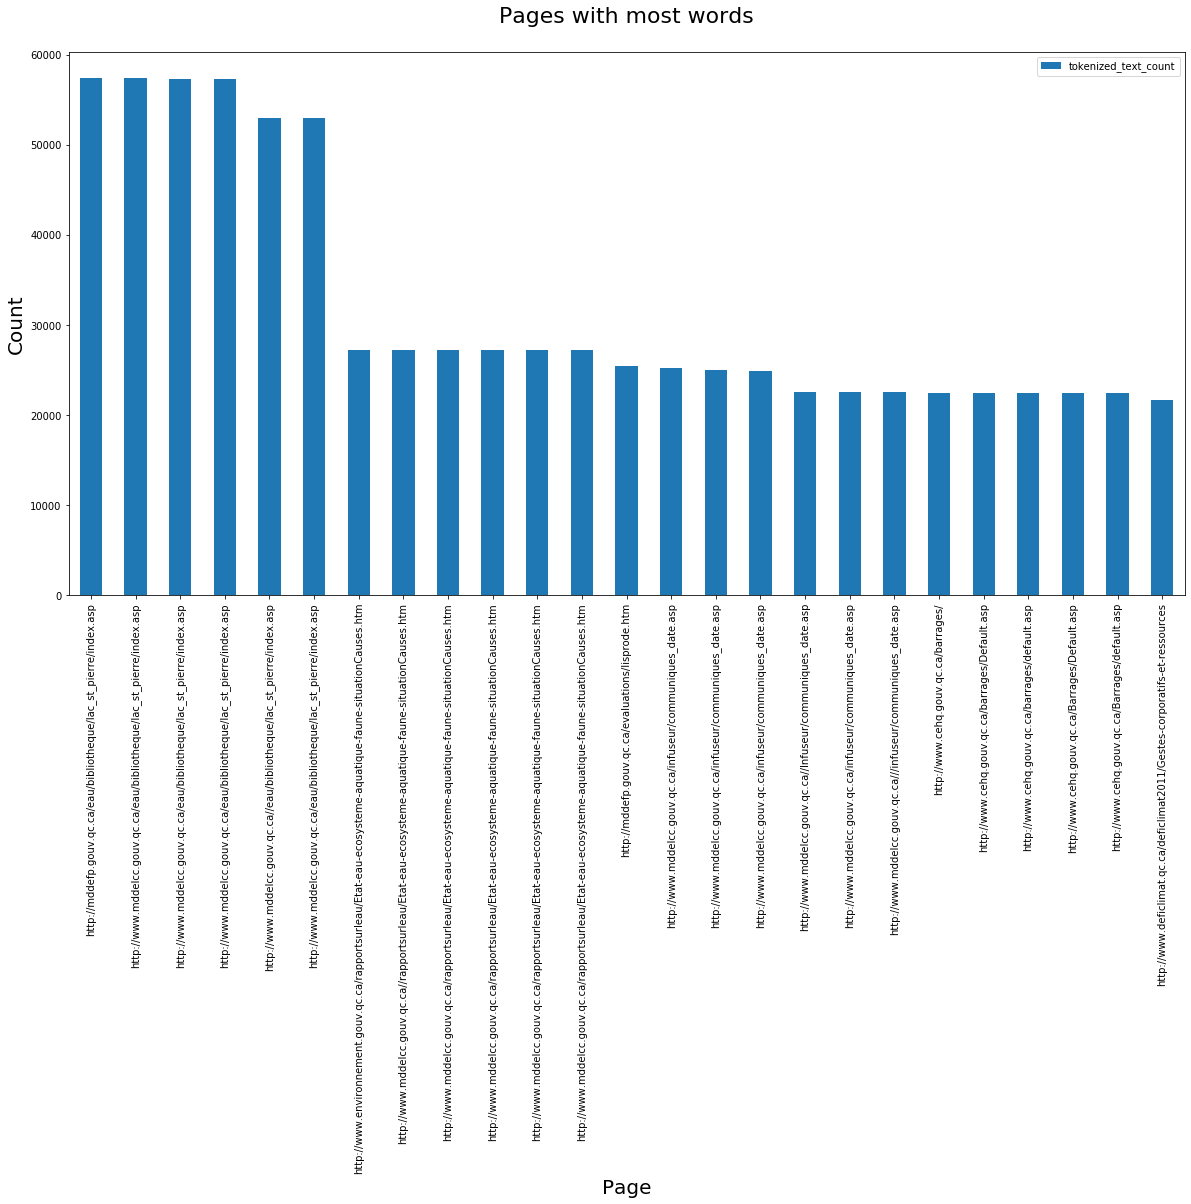

In [0]:
word_count_chart = word_count.plot(kind='bar', x='url', figsize=(20,10))
word_count_chart.set_title('Pages with most words\n', fontsize=22)
word_count_chart.set_ylabel('Count', fontsize=20)
word_count_chart.set_xlabel('Page', fontsize=20)


### Sentiment Analysis

Let's start with sentiment analysis. We'll take a smaller segment of the dataset here since we're limited by RAM.


In [0]:
text_blob = TextBlob("".join(pages['content'].head(10000).values))
text_blob.sentiment

Sentiment(polarity=0.06575735808926225, subjectivity=0.49421606804282414)

### n-grams

In [0]:
from nltk.util import ngrams

ngrams(text_blob, 5)

<generator object ngrams at 0x7ff8d7e590a0>

### Word Cloud

Word clouds are always fun, right?!

Let's setup some dependcies here, and install the [`word_cloud`](https://github.com/amueller/word_cloud) library, and setup some stop words via `nltk`.

We'll take about 50% of the dataset here since we're limited by RAM.


In [0]:
%%capture

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

french_stop_words = set(stopwords.words('french'))

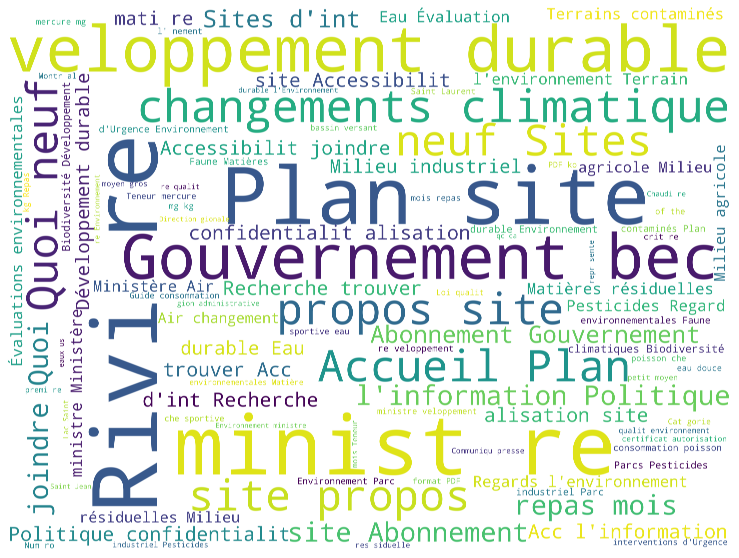

In [0]:
wordcloud = WordCloud(stopwords=french_stop_words, width=2000, height=1500, scale=10, max_font_size=250, max_words=100, background_color="white").generate("".join(pages['content'].head(200000).values))
plt.figure(figsize=[35,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()